In [2]:
import pandas as pd
import plotly.express as px
import geopandas
import matplotlib.pyplot as plt
import geodatasets
from shapely.geometry import Point
import folium

In [3]:
# load county data and filter (CA FIPS code is 06)
county = geopandas.read_file("ne_10m_admin_2_counties")
california = county[county["ISO_3166_2"] == "US-06"]

# load housing data
housing = pd.read_csv("housing-subset.csv")

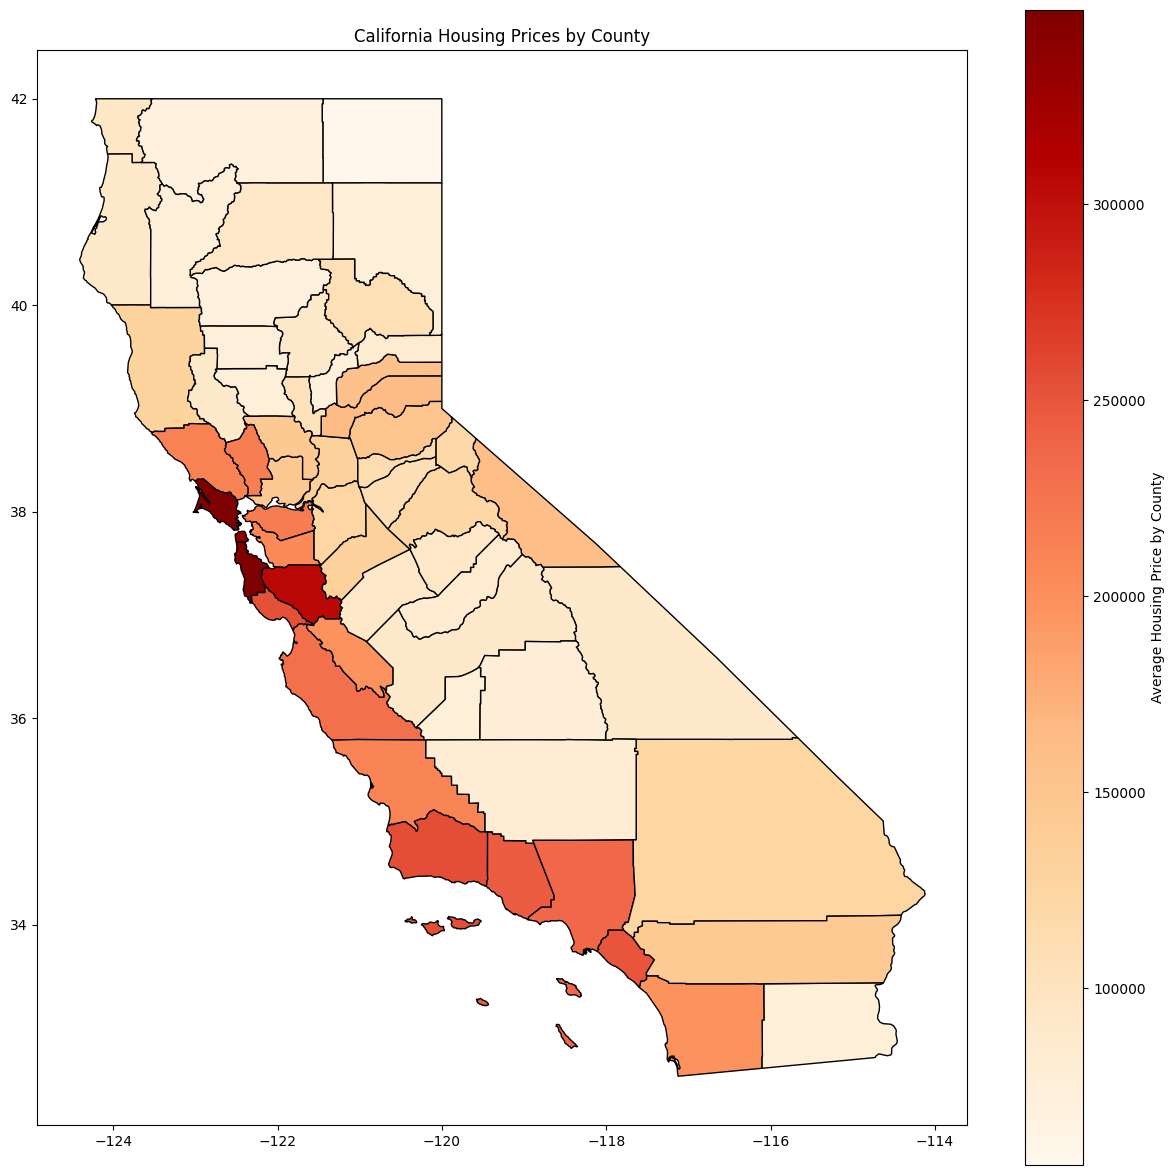

In [4]:
## STATIC

# convert longitude/latitude to Point
geometry = [Point(xy) for xy in zip(housing["longitude"], housing["latitude"])]
housing_gdf = geopandas.GeoDataFrame(housing, geometry=geometry)

# coordinate reference system
housing_gdf = housing_gdf.set_crs(california.crs, allow_override=True)

# join ca county and housing data
housing_with_county = geopandas.sjoin(housing_gdf, california, how="left", predicate="within")

# take median house value by county
county_prices = housing_with_county.groupby("NAME")["median_house_value"].mean().reset_index()

ca_prices = california.set_index("NAME").join(county_prices.set_index("NAME"))

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ca_prices.plot(column="median_house_value", ax=ax, legend=True,
               legend_kwds={"label": "Average Housing Price by County",
                            "orientation": "vertical"},
                            cmap="OrRd",
                            edgecolor="black")

plt.title("California Housing Prices by County")
plt.show()

In [5]:
## INTERACTIVE

# get median house value and income by county
county_data = housing_with_county.groupby("NAME").agg({
    "median_house_value": "mean",
    "median_income": "mean"
}).reset_index()

california_with_data = california.set_index("NAME").join(county_data.set_index("NAME"))

# color scale is median house value
# hovering shows the name of the county
# county name, median house value, and median income are shown on click
m = california_with_data.explore(
    column="median_house_value",
    cmap="OrRd",
    tooltip=["NAME"],
    popup=["NAME", "median_house_value", "median_income"],
    name="California Housing Prices by County",
    scheme="naturalbreaks", 
    k=8, 
    legend=True,
    legend_kwds={"colorbar": False}
)

folium.TileLayer("CartoDB positron", show=True).add_to(m)
folium.LayerControl().add_to(m)

m